In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import xarray as xr
import glob
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

import sensor_info
import model_class
import dataset_class
import local_functions
import stats
import model_operations

satellite = sensor_info.satellite
sensor = sensor_info.sensor

In [2]:
model_tree = model_operations.load_model_tree()

In [6]:
model_tree

{'GMI_GPM_channel_predictor_19V_ocean_no10': channel_predictor(
   (l1): Linear(in_features=10, out_features=256, bias=True)
   (l2): Linear(in_features=256, out_features=256, bias=True)
   (l3): Linear(in_features=256, out_features=256, bias=True)
   (l4): Linear(in_features=256, out_features=1, bias=True)
   (actvn): GELU(approximate='none')
 ),
 'GMI_GPM_channel_predictor_19H_ocean_no10': channel_predictor(
   (l1): Linear(in_features=10, out_features=256, bias=True)
   (l2): Linear(in_features=256, out_features=256, bias=True)
   (l3): Linear(in_features=256, out_features=256, bias=True)
   (l4): Linear(in_features=256, out_features=1, bias=True)
   (actvn): GELU(approximate='none')
 ),
 'GMI_GPM_channel_predictor_24V_ocean_no10': channel_predictor(
   (l1): Linear(in_features=10, out_features=256, bias=True)
   (l2): Linear(in_features=256, out_features=256, bias=True)
   (l3): Linear(in_features=256, out_features=256, bias=True)
   (l4): Linear(in_features=256, out_features=1, bi

In [3]:
'''
Load in test data and predict Tbs:
'''

#Ocean
sfc = [1]

with xr.open_dataset(f'training_data/{satellite}_training_data.nc') as f:
        
    sfctype = f.sfctype.values

    correct_sfc = sfctype == 1

    Tbs = f.Tbs.values[correct_sfc]
    sfctype = sfctype[correct_sfc]

if Tbs.shape[0] > 5.0e+06:
    Tbs = Tbs[:5_000_000,:]
    sfctype = sfctype[:5_000_000]

Tbs = Tbs[:,2:]

#---Split data into train/test/val:
train_indcs, test_indcs, val_indcs = local_functions.split_data_indcs(Tbs)

Tbs_test = Tbs[test_indcs]
sfctype  = sfctype[test_indcs]

y_true = Tbs_test

#Run predictions on test data:
y_pred = model_operations.run_predictions(y_true, sfctype, model_tree, keep_dims=False)

In [4]:
'''
Calculate error statistics
'''


rmse = stats.root_mean_squared_error(y_pred, y_true, axis=0)
mse = stats.mean_squared_error(y_pred, y_true, axis=0)
mae = stats.mean_absolute_error(y_pred, y_true, axis=0)

error = y_pred - y_true
mean_error = np.mean(error, axis=0)
std_error  = np.std(error, axis=0)

print('Error stats:')
print('mean: ', mean_error)
print('std: ', std_error)

mean_error.astype(np.float32).tofile('mean_ocn.arr', sep='', format='unformatted')
std_error.astype(np.float32).tofile('std_ocn.arr', sep='', format='unformatted')

Error stats:
mean:  [ 0.04154019 -0.1333981   0.12401876  0.06545382 -0.01117156 -0.11191753
  0.06527629 -0.00851487 -0.04779174  0.01536986 -0.10732043]
std:  [0.7409495  0.8680544  1.1492563  0.6496949  0.85990965 0.6858723
 1.1832353  0.9038886  1.2520081  1.9910513  1.0123868 ]


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_835334/53585005.py:10: SyntaxWarning: invalid escape sequence '\m'
  label=f'{channel}, $\mu$={mean_error[ichan]:.2f}, $\sigma$={std_error[ichan]:.2f}')
/tmp/ipykernel_835334/53585005.py:10: SyntaxWarning: invalid escape sequence '\s'
  label=f'{channel}, $\mu$={mean_error[ichan]:.2f}, $\sigma$={std_error[ichan]:.2f}')


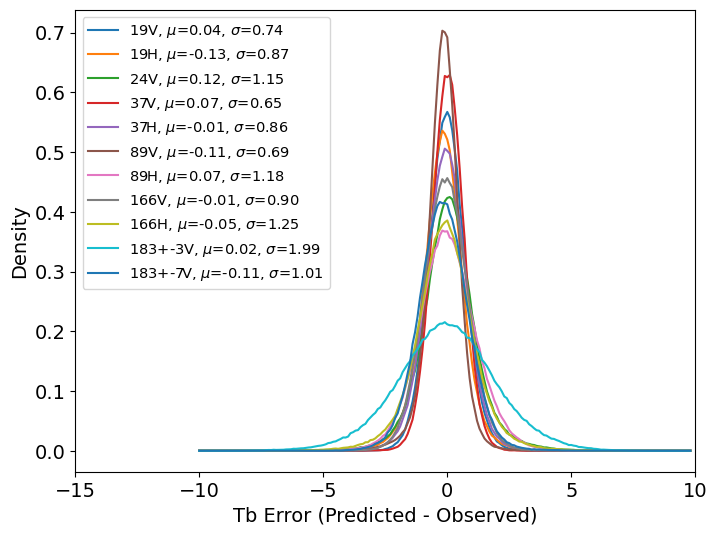

In [5]:
nchans = sensor_info.nchannels

bin_edges = np.arange(-10,10,0.1)
dens = np.zeros([bin_edges.size - 1,nchans])

plt.figure(figsize=[8,6])
for ichan,channel in enumerate(sensor_info.feature_descriptions):
    dens[:,ichan], bin_edges = np.histogram(error[:,ichan], bins=bin_edges, density=True)
    plt.plot(bin_edges[:-1], dens[:,ichan], 
             label=f'{channel}, $\mu$={mean_error[ichan]:.2f}, $\sigma$={std_error[ichan]:.2f}')

plt.xlim(-15,10)
plt.tick_params('both', labelsize=14)
plt.xlabel('Tb Error (Predicted - Observed)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper left', fontsize=10.5)


plt.show()


<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_835334/526902025.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Normalized Error [$\sigma$]', fontsize=14)


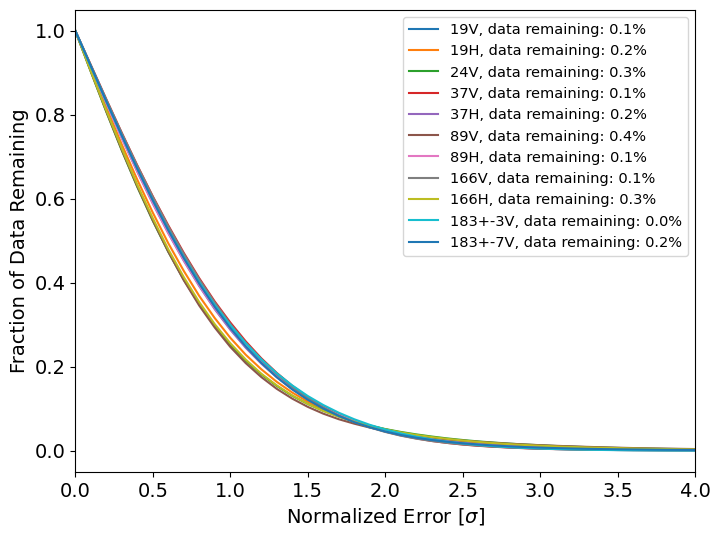

In [6]:
'''
Plot fraction of data that remains as a function of 
standard deviation (sigma) from the mean.
'''

bin_edges = np.arange(0,10,0.1)
#Get errors in units of sigma
norm_error = (error - error.mean(axis=0)) / error.std(axis=0)

frac_rem = np.zeros([bin_edges.size - 1, nchans])
for ichan, channel in enumerate(sensor_info.feature_descriptions):
    #Get histogram of absolute error [sigma] as a function of sigma
    counts, bin_edges = np.histogram(np.abs(norm_error[:,ichan]), bins=bin_edges)

    #Get reverse cumulative sum of counts as a function of sigma:
    revcumsum = np.flip(np.cumsum(np.flip(counts)))

    #Calculate the fraction of remaining data as a function of sigma:
    frac = revcumsum / counts.sum()

    #Save this result. It is the fraction of data remaining as we move
    #   farther from the mean in sigma space.
    frac_rem[:,ichan] = frac

plt.figure(figsize=[8,6])
for ichan,channel in enumerate(sensor_info.feature_descriptions):
    plt.plot(bin_edges[:-1], frac_rem[:,ichan], 
             label=f'{channel}, data remaining: {frac_rem[40,ichan]*100.:.1f}%')

plt.xlim(0,4)
plt.tick_params('both', labelsize=14)
plt.xlabel('Normalized Error [$\sigma$]', fontsize=14)
plt.ylabel('Fraction of Data Remaining', fontsize=14)
plt.legend(fontsize=10.5)
plt.show()


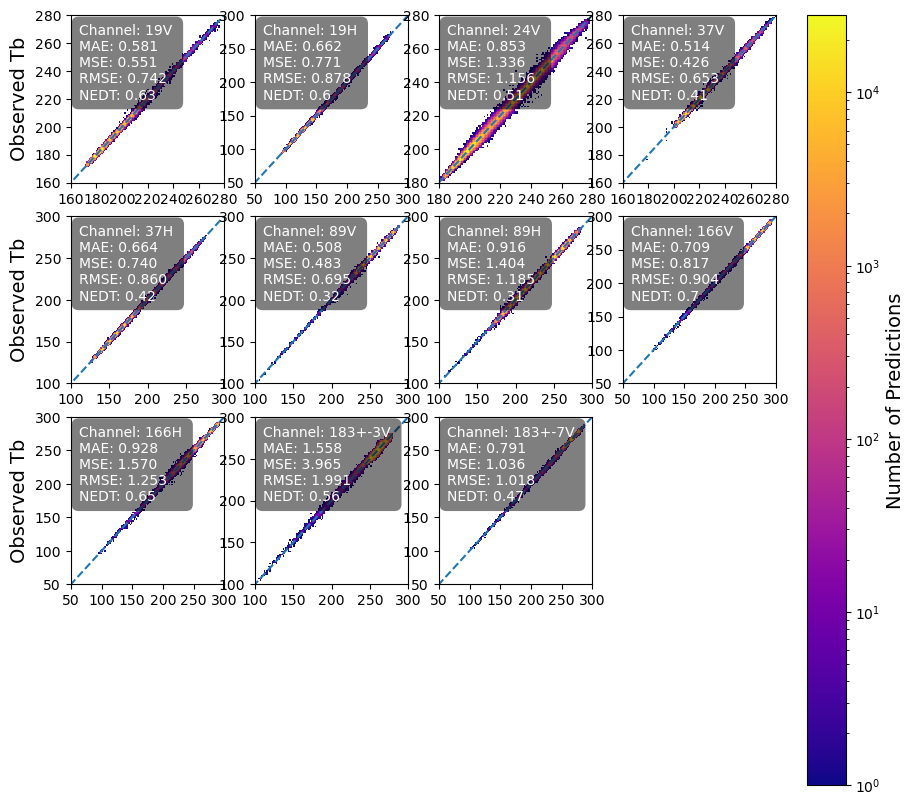

In [7]:
'''
Plot results
'''

nedt = sensor_info.nedt

nrows, ncols = (4,4)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,10])

i = 0

channels2plot = sensor_info.feature_descriptions
for irow in range(nrows):
    for icol in range(ncols):
        if i >= len(channels2plot):
            ax[irow,icol].axis('off')
            continue
        channel = channels2plot[i]
        min_lim, max_lim = y_true[:,i].min(), y_true[:,i].max()
        mesh = ax[irow,icol].hist2d(y_pred[:,i],y_true[:,i], bins=100, norm=LogNorm(), cmap='plasma',
                             range=[[min_lim,max_lim],[min_lim,max_lim]])
        ticks = ax[irow,icol].get_yticks()
        ax[irow,icol].set_xticks(ticks); ax[irow,icol].set_yticks(ticks)
        ax[irow,icol].plot(np.arange(0,400), np.arange(0,400), linestyle='--')
        ax[irow, icol].text(0.05, 0.95, f'Channel: {channel} \nMAE: {mae[i]:.3f} \nMSE: {mse[i]:.3f} \nRMSE: {rmse[i]:.3f} \nNEDT: {nedt[i]}', 
                            ha='left', va='top', 
                            transform=ax[irow, icol].transAxes, color='white', fontsize=10, 
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.5'))

        if icol == 0:
            ax[irow,icol].set_ylabel('Observed Tb', fontsize=14)

        if irow == nrows - 1:
            ax[irow,icol].set_xlabel('Predicted Tb', fontsize=14)
        i += 1

#ax[-1,-1].set_yticks([]), ax[-1,-1].set_xticks([])
cbar = fig.colorbar(mesh[3], ax=ax, orientation='vertical', fraction=0.05, pad=0.04 )
cbar.set_label('Number of Predictions', fontsize=14)
plt.show()

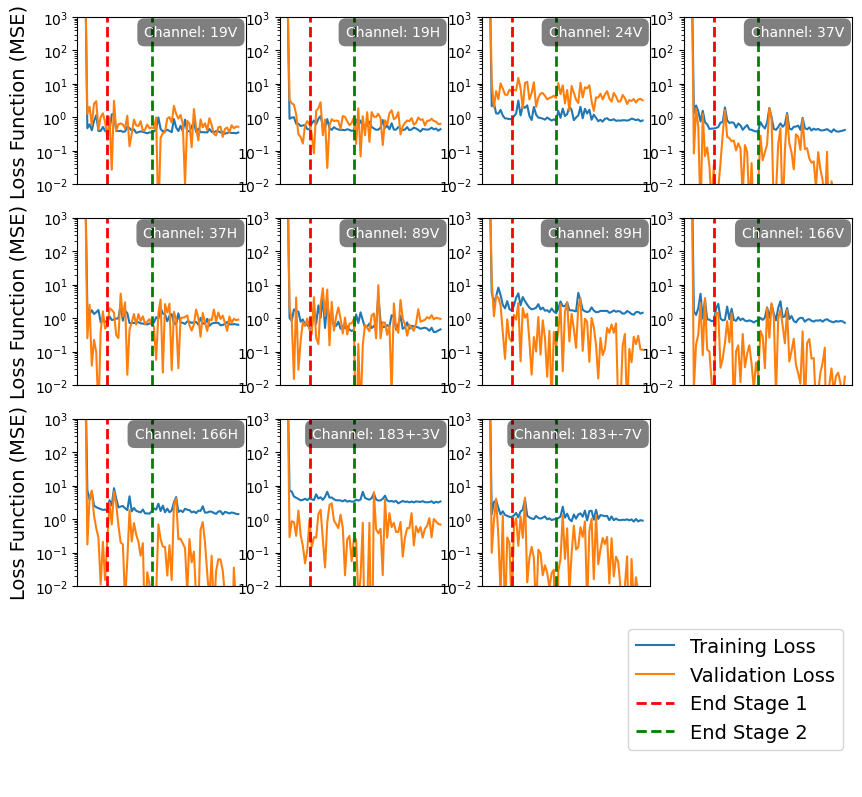

In [8]:
'''
Plot training diagnostics:
'''

loss_files = glob.glob('diagnostics/loss_data*.nc')

loss_data = {}

for ichan,channel in enumerate(sensor_info.feature_descriptions):

    loss_file = glob.glob(f'diagnostics/loss_data_{channel}_ocean.nc')[0]
    
    with xr.open_dataset(loss_file) as f:
        nstages = 3
        
        nbatches, nepochs1 = f.LossStage1.shape
        nbatches, nepochs2 = f.LossStage2.shape
        nbatches, nepochs3 = f.LossStage3.shape

        ntotepochs = nepochs1 + nepochs2 + nepochs3

        loss = np.zeros([ntotepochs*nbatches],dtype='f')
        valloss = np.zeros([ntotepochs*nbatches],dtype='f')

        beg1 = 0
        end1 = nbatches*nepochs1
        beg2 = end1
        end2 = end1 + nbatches*nepochs2
        beg3 = end2
        end3 = end2 + nbatches*nepochs3

        loss[beg1:end1] = f.LossStage1.T.values.reshape(-1)
        loss[beg2:end2] = f.LossStage2.T.values.reshape(-1)
        loss[beg3:end3] = f.LossStage3.T.values.reshape(-1)
        valloss[beg1:end1] = f.ValidationLossStage1.T.values.reshape(-1)
        valloss[beg2:end2] = f.ValidationLossStage2.T.values.reshape(-1)
        valloss[beg3:end3] = f.ValidationLossStage3.T.values.reshape(-1)

    loss_data[f'training_loss_{channel}'] = loss
    loss_data[f'validation_loss_{channel}'] = valloss


fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,10])

i = 0
for irow in range(nrows):
    for icol in range(ncols):
        if i >= len(channels2plot):
            ax[irow, icol].axis('off')  # hide unused panels
            continue
        channel = channels2plot[i]
        line1 = ax[irow,icol].plot(loss_data[f'training_loss_{channel}'][::2000], label='Training Loss')
        line2 = ax[irow,icol].plot(loss_data[f'validation_loss_{channel}'][::2000], label='Validation Loss')
        ax[irow,icol].set_yscale('log')
        ax[irow,icol].set_ylim(0.01,1000)
        ax[irow, icol].text(0.95, 0.95, f'Channel: {channel}', 
                            ha='right', va='top', 
                            transform=ax[irow, icol].transAxes, color='white', fontsize=10, 
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.5'))

        line3 = ax[irow,icol].axvline(nbatches*nepochs1/2000, color='r', linestyle='--', linewidth=2, label='End Stage 1')
        line4 = ax[irow,icol].axvline(nbatches*(nepochs2+nepochs1)/2000, color='g', linestyle='--', linewidth=2, label='End Stage 2')


        if i == 0:
            # Capture legend handles from the first plot
            legend_handles, legend_labels = ax[irow, icol].get_legend_handles_labels()

        if icol == 0:
            ax[irow,icol].set_ylabel('Loss Function (MSE)', fontsize=14)
        if irow == nrows-1:
            ax[irow,icol].set_xlabel('Training', fontsize=14)


        ax[irow,icol].set_xticks([])
        i += 1


ax[nrows-1, ncols-1].legend(legend_handles, legend_labels, loc='upper right', fontsize=14)
plt.show()

In [10]:
'''
Load in test data and predict Tbs: Nonocean
'''

with xr.open_dataset(f'training_data/{satellite}_training_data.nc') as f:
        
    sfctype = f.sfctype.values

    correct_sfc = sfctype > 1

    Tbs = f.Tbs.values[correct_sfc]
    sfctype = sfctype[correct_sfc]

Tbs = Tbs[:,2:]

# if Tbs.shape[0] > 5.0e+06:
#     Tbs = Tbs[:5_000_000,:]
#     sfctype = sfctype[:5_000_000]
#---Split data into train/test/val:
train_indcs, test_indcs, val_indcs = local_functions.split_data_indcs(Tbs)

Tbs_test = Tbs[test_indcs]
sfctype  = sfctype[test_indcs]

y_true = Tbs_test

#Run predictions on test data:
y_pred = model_operations.run_predictions(y_true, sfctype, model_tree, keep_dims=False)

In [11]:
'''
Calculate error statistics
'''


rmse = stats.root_mean_squared_error(y_pred, y_true, axis=0)
mse = stats.mean_squared_error(y_pred, y_true, axis=0)
mae = stats.mean_absolute_error(y_pred, y_true, axis=0)

error = y_pred - y_true
mean_error = np.mean(error, axis=0)
std_error  = np.std(error, axis=0)

print('Error stats:')
print('mean: ', mean_error)
print('std: ', std_error)

mean_error.astype(np.float32).tofile('mean_non.arr', sep='', format='unformatted')
std_error.astype(np.float32).tofile('std_non.arr', sep='', format='unformatted')

Error stats:
mean:  [ 0.00267702  0.10260954  0.01355218  0.01066761 -0.02233288  0.00569288
 -0.04040343  0.04727607 -0.01190451 -0.18255138 -0.00946572]
std:  [1.077634   1.8477513  1.0088912  0.90009046 1.152721   1.0999695
 1.3125854  1.1840973  1.4009058  2.3846383  1.8200797 ]


<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_835334/4079396312.py:10: SyntaxWarning: invalid escape sequence '\m'
  label=f'{channel}, $\mu$={mean_error[ichan]:.2f}, $\sigma$={std_error[ichan]:.2f}')
/tmp/ipykernel_835334/4079396312.py:10: SyntaxWarning: invalid escape sequence '\s'
  label=f'{channel}, $\mu$={mean_error[ichan]:.2f}, $\sigma$={std_error[ichan]:.2f}')


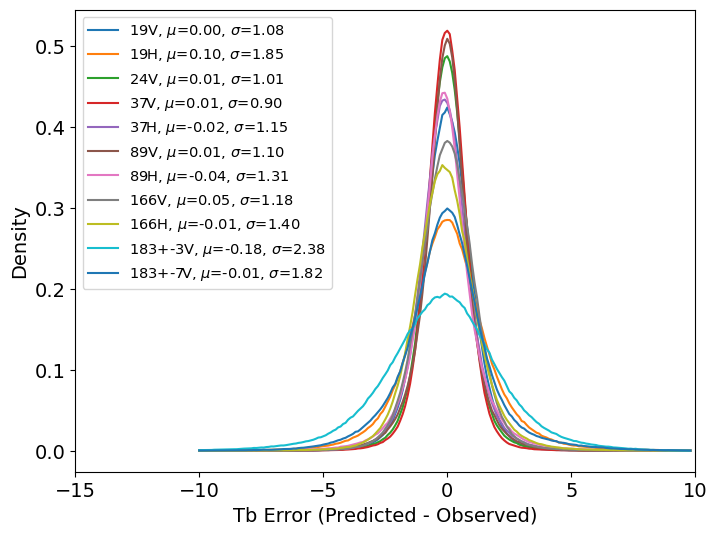

In [12]:
#nchans = 13

bin_edges = np.arange(-10,10,0.1)
dens = np.zeros([bin_edges.size - 1,nchans])

plt.figure(figsize=[8,6])
for ichan,channel in enumerate(sensor_info.feature_descriptions):
    dens[:,ichan], bin_edges = np.histogram(error[:,ichan], bins=bin_edges, density=True)
    plt.plot(bin_edges[:-1], dens[:,ichan], 
             label=f'{channel}, $\mu$={mean_error[ichan]:.2f}, $\sigma$={std_error[ichan]:.2f}')

plt.xlim(-15,10)
plt.tick_params('both', labelsize=14)
plt.xlabel('Tb Error (Predicted - Observed)', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(loc='upper left', fontsize=10.5)


plt.show()


<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_835334/526902025.py:32: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Normalized Error [$\sigma$]', fontsize=14)


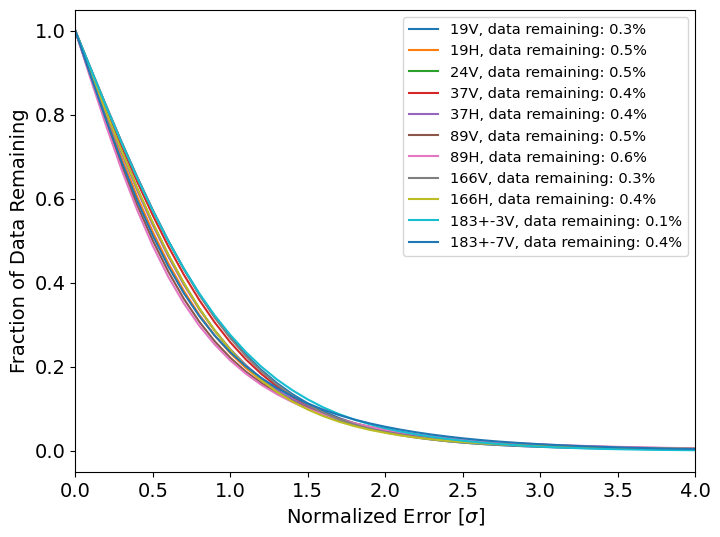

In [13]:
'''
Plot fraction of data that remains as a function of 
standard deviation (sigma) from the mean.
'''

bin_edges = np.arange(0,10,0.1)
#Get errors in units of sigma
norm_error = (error - error.mean(axis=0)) / error.std(axis=0)

frac_rem = np.zeros([bin_edges.size - 1, nchans])
for ichan, channel in enumerate(sensor_info.feature_descriptions):
    #Get histogram of absolute error [sigma] as a function of sigma
    counts, bin_edges = np.histogram(np.abs(norm_error[:,ichan]), bins=bin_edges)

    #Get reverse cumulative sum of counts as a function of sigma:
    revcumsum = np.flip(np.cumsum(np.flip(counts)))

    #Calculate the fraction of remaining data as a function of sigma:
    frac = revcumsum / counts.sum()

    #Save this result. It is the fraction of data remaining as we move
    #   farther from the mean in sigma space.
    frac_rem[:,ichan] = frac

plt.figure(figsize=[8,6])
for ichan,channel in enumerate(sensor_info.feature_descriptions):
    plt.plot(bin_edges[:-1], frac_rem[:,ichan], 
             label=f'{channel}, data remaining: {frac_rem[40,ichan]*100.:.1f}%')

plt.xlim(0,4)
plt.tick_params('both', labelsize=14)
plt.xlabel('Normalized Error [$\sigma$]', fontsize=14)
plt.ylabel('Fraction of Data Remaining', fontsize=14)
plt.legend(fontsize=10.5)
plt.show()


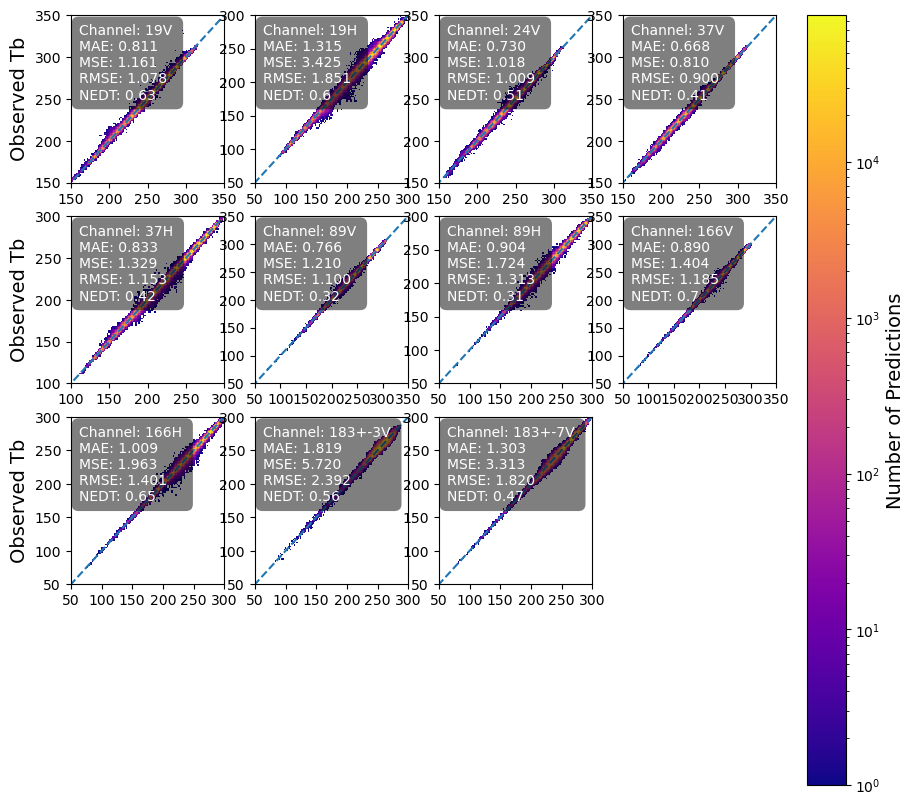

In [14]:
'''
Plot results
'''

nedt = sensor_info.nedt

nrows, ncols = (4,4)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,10])

i = 0

channels2plot = sensor_info.feature_descriptions
for irow in range(nrows):
    for icol in range(ncols):
        if i >= len(channels2plot):
            ax[irow,icol].axis('off')
            continue
        channel = channels2plot[i]
        min_lim, max_lim = y_true[:,i].min(), y_true[:,i].max()
        mesh = ax[irow,icol].hist2d(y_pred[:,i],y_true[:,i], bins=100, norm=LogNorm(), cmap='plasma',
                             range=[[min_lim,max_lim],[min_lim,max_lim]])
        ticks = ax[irow,icol].get_yticks()
        ax[irow,icol].set_xticks(ticks); ax[irow,icol].set_yticks(ticks)
        ax[irow,icol].plot(np.arange(0,400), np.arange(0,400), linestyle='--')
        ax[irow, icol].text(0.05, 0.95, f'Channel: {channel} \nMAE: {mae[i]:.3f} \nMSE: {mse[i]:.3f} \nRMSE: {rmse[i]:.3f} \nNEDT: {nedt[i]}', 
                            ha='left', va='top', 
                            transform=ax[irow, icol].transAxes, color='white', fontsize=10, 
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.5'))

        if icol == 0:
            ax[irow,icol].set_ylabel('Observed Tb', fontsize=14)

        if irow == nrows - 1:
            ax[irow,icol].set_xlabel('Predicted Tb', fontsize=14)
        i += 1

#ax[-1,-1].set_yticks([]), ax[-1,-1].set_xticks([])
cbar = fig.colorbar(mesh[3], ax=ax, orientation='vertical', fraction=0.05, pad=0.04 )
cbar.set_label('Number of Predictions', fontsize=14)
plt.show()

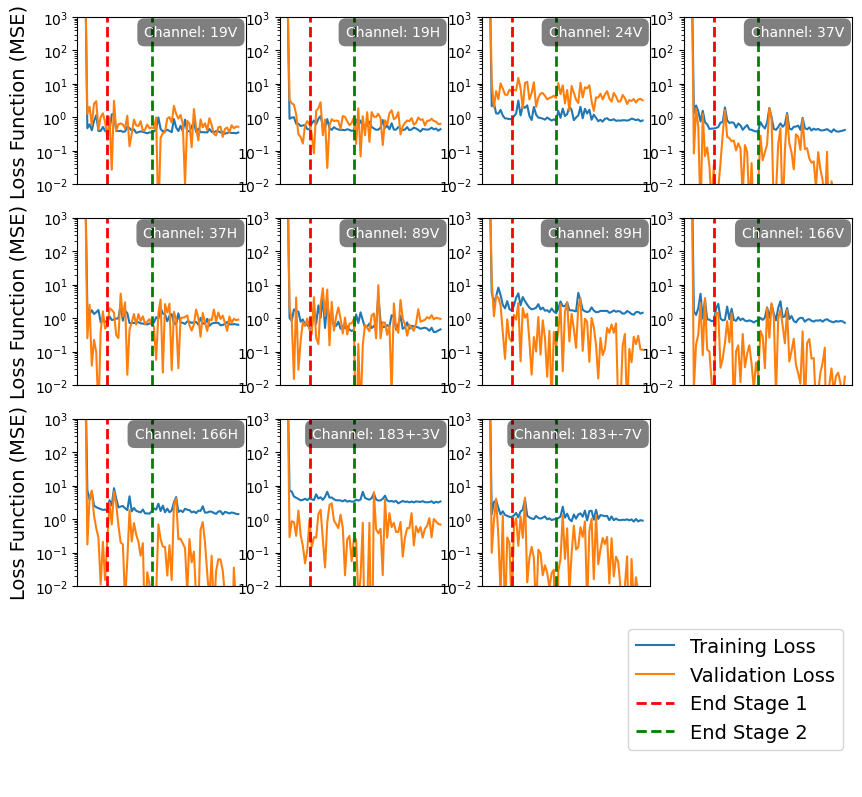

In [15]:
'''
Plot training diagnostics:
'''

loss_files = glob.glob('diagnostics/loss_data*.nc')

loss_data = {}

for ichan,channel in enumerate(sensor_info.feature_descriptions):

    loss_file = glob.glob(f'diagnostics/loss_data_{channel}_ocean.nc')[0]
    
    with xr.open_dataset(loss_file) as f:
        nstages = 3
        
        nbatches, nepochs1 = f.LossStage1.shape
        nbatches, nepochs2 = f.LossStage2.shape
        nbatches, nepochs3 = f.LossStage3.shape

        ntotepochs = nepochs1 + nepochs2 + nepochs3

        loss = np.zeros([ntotepochs*nbatches],dtype='f')
        valloss = np.zeros([ntotepochs*nbatches],dtype='f')

        beg1 = 0
        end1 = nbatches*nepochs1
        beg2 = end1
        end2 = end1 + nbatches*nepochs2
        beg3 = end2
        end3 = end2 + nbatches*nepochs3

        loss[beg1:end1] = f.LossStage1.T.values.reshape(-1)
        loss[beg2:end2] = f.LossStage2.T.values.reshape(-1)
        loss[beg3:end3] = f.LossStage3.T.values.reshape(-1)
        valloss[beg1:end1] = f.ValidationLossStage1.T.values.reshape(-1)
        valloss[beg2:end2] = f.ValidationLossStage2.T.values.reshape(-1)
        valloss[beg3:end3] = f.ValidationLossStage3.T.values.reshape(-1)

    loss_data[f'training_loss_{channel}'] = loss
    loss_data[f'validation_loss_{channel}'] = valloss

nrows, ncols = (4,4)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[10,10])

i = 0
for irow in range(nrows):
    for icol in range(ncols):
        if i >= len(channels2plot):
            ax[irow, icol].axis('off')  # hide unused panels
            continue
        channel = channels2plot[i]
        line1 = ax[irow,icol].plot(loss_data[f'training_loss_{channel}'][::2000], label='Training Loss')
        line2 = ax[irow,icol].plot(loss_data[f'validation_loss_{channel}'][::2000], label='Validation Loss')
        ax[irow,icol].set_yscale('log')
        ax[irow,icol].set_ylim(0.01,1000)
        ax[irow, icol].text(0.95, 0.95, f'Channel: {channel}', 
                            ha='right', va='top', 
                            transform=ax[irow, icol].transAxes, color='white', fontsize=10, 
                            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.5'))

        line3 = ax[irow,icol].axvline(nbatches*nepochs1/2000, color='r', linestyle='--', linewidth=2, label='End Stage 1')
        line4 = ax[irow,icol].axvline(nbatches*(nepochs2+nepochs1)/2000, color='g', linestyle='--', linewidth=2, label='End Stage 2')


        if i == 0:
            # Capture legend handles from the first plot
            legend_handles, legend_labels = ax[irow, icol].get_legend_handles_labels()

        if icol == 0:
            ax[irow,icol].set_ylabel('Loss Function (MSE)', fontsize=14)
        if irow == nrows-1:
            ax[irow,icol].set_xlabel('Training', fontsize=14)


        ax[irow,icol].set_xticks([])
        i += 1


ax[nrows-1, ncols-1].legend(legend_handles, legend_labels, loc='upper right', fontsize=14)
plt.show()